# Preparing `efficientNetB1` for Hailo-8

This notebook quantizes the efficientNetB1 model previously saved in the MODEL_ORIG_HAR file.  

Note that the model script has the line:

<i> 'quantization_param(fc33, force_range_out=[0, 1])\n' </i>

It was put to avoid a quantization error because of unsuitable calibration data.

The error thrown was:

<i> BackendQuantizationException: Quantization failed in layer due to unsupported required slope -10 where the minimum allowed is -4at layer efficientNetB1/fc33, ActivationType.silu, limvals_weights: [-0.539730266620856, 0.539730266620856], limvals_in: [-0.29422318935394287, 4.707571], limvals_out: [-0.00017942233534995466, 0]. This error raises when the data or weight range is not balanced. Mostly happends when using random data, the input is not normalized properly or there is no batchnorm in the network. </i>

Please replace the calibration data and commnent/remove the line before trying again.

For calibration, a set of at least 1024 images must be provided. Please set the below variable IMAGE_DIR accordingly.
The PC must have a GPU in order to enable the default optimization level 1. For full information see the Dataflow Compiler user guide / Model optimization section.

For higher fps, uncomment the line

<i> 'model_optimization_flavor(optimization_level=2, compression_level=4, batch_size=2)\n' </i>


---
***Change log***

Jul 1, 2022: 
- Updated for DFC 3.18
- Now at least 1024 images must be provided for calibration
June 24, 2022:
- Added code get the number of *.jpg files in directory IMAGE_DIR in case quantization fine tune is alter needed. For now keep MX_NUM_IMAGES=64
- Bug fix: make sure to call runner.load_model_script() to pass model script file 'model.alls'. Previously this call was missing.
- Simplified the 'model.alls' file

June 21, 2022: First version created

---

In [24]:
from pathlib import Path
import os
import fnmatch

MODEL      = 'efficientNetB1'

INPUT_WIDTH= 150
INPUT_HEIGHT= 150

# Set IMAGE_DIR to point to your input *.jpg images which will be used for calibration
HOME_DIR = str(Path.home())
WORKDIR= str(Path.cwd())
#IMAGE_DIR = HOME_DIR + '/workspace/datasets/coco/val2017'
IMAGE_DIR = WORKDIR + '/lp_data_cropped'
# Set max number of images used for calibration
MAX_NUM_IMAGES= len(fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg'))
#MAX_NUM_IMAGES= 64
print('The dataset has ' + str(MAX_NUM_IMAGES) + ' images')

MODEL_ORIG_HAR= MODEL + '_orig.har'

The dataset has 205 images


In [25]:
# Find Virtual environment path
import subprocess as sp
python3Path = sp.getoutput('which python3')
endPos= python3Path.find("/bin/python3")
if (endPos== -1):
    print ("Error could not find virtualenv path")
else:
    VENV_PATH= python3Path[0:endPos]
print("Virtual environment located at " + VENV_PATH)
        

Virtual environment located at /home/victorc/workspace/hailo_ai_sw_suite/hailo_venv


In [26]:
import tensorflow as tf
import numpy as np
from hailo_sdk_client import ClientRunner, __version__, NNFramework


In [27]:
print('TF version:', tf.__version__)
print('Hailo DFC version', __version__)

TF version: 2.12.0
Hailo DFC version 3.26.0


### Quantizing the model

For simplicity, in this case we're going to have a false quantization. This will NOT produce real results, until quantizing with real data

In [28]:
import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [45]:
runner = ClientRunner(hw_arch='hailo8', har=MODEL_ORIG_HAR)

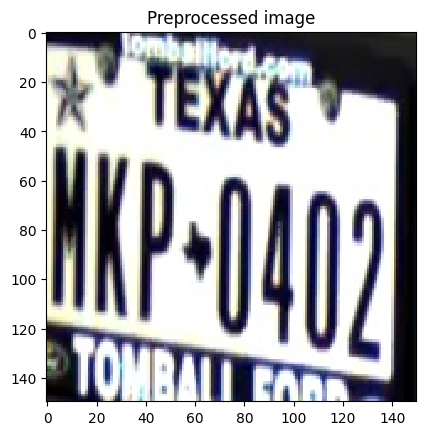

In [46]:
def convert_rgb_to_yuv(image):
    transition_matrix = np.array([[0.2568619, -0.14823364, 0.43923104],
                                  [0.5042455, -0.2909974, -0.367758],
                                  [0.09799913, 0.43923104, -0.07147305]])
    image = np.matmul(image, transition_matrix)
    image += [16, 128, 128]
    return image

def preproc_resize(path):  
    pil_image = Image.open(path)
    ip = pil_image.resize([INPUT_WIDTH, INPUT_HEIGHT])
    ip = np.array(ip)
    return ip

files = os.listdir(IMAGE_DIR)
files.sort()
files = files[0:MAX_NUM_IMAGES]
idx= 0
calib_dataset = np.zeros((len(files), INPUT_HEIGHT, INPUT_WIDTH, 3), dtype=np.float32)
for filename in files:
    if(os.path.isfile(os.path.join(IMAGE_DIR, filename)) and ('.jpg' in filename)):
        img_preproc= preproc_resize(os.path.join(IMAGE_DIR,filename))
        calib_dataset[idx,:,:,:] = img_preproc.astype(np.uint8)
        idx=idx+1
        
plt.imshow(np.array(calib_dataset[idx-1,:,:,:], np.uint8), interpolation='nearest')
plt.title('Preprocessed image')
plt.show()

In [47]:
alls_lines = [
    'normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n',
    # Comment below lines after finding a suitable calibration dataset
    #'quantization_param(fc1, force_range_out=[0, 1])\n',
    'quantization_param(fc33, force_range_out=[0, 1])\n',
    'pre_quantization_optimization(se_optimization, method=tse, mode=sequential,  count=23, tile_height=[5,5,2,2,2,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5])\n'
    # 'allocator_param(automatic_ddr= False )\n', # Recommended for running on system with 1 or 2 PCIe lanes
    # -- Below reduces weights memory by 80% for higher fps with optimization level=2 to improve accuracy
    # Recommend to have GPU for reduced optimization time
    #'model_optimization_config(compression_params, auto_4bit_weights_ratio=0.2)\n'
    'model_optimization_flavor(optimization_level=1, compression_level=3, batch_size=2)\n'  # Batch size is 8 by default, adjust it according to GPU memory
]

open('model.alls','w').writelines(alls_lines)


In [48]:
runner.load_model_script('model.alls')

runner.optimize(calib_dataset)

MODEL_QUANTIZED_HAR= MODEL + '_quantized.har'
runner.save_har(MODEL_QUANTIZED_HAR)

[info] Loading model script commands to efficientNetB1 from model.alls
[warning] Running TSE - this will affect your full precision results
[info] Starting Model Optimization
[warning] Reducing compression ratio to 0 because the number of parameters in the network is not large enough (18M and need at least 20M). Can be enforced using model_optimization_config(compression_params, auto_4bit_weights_ratio=0.6000000000000001)
[info] Model received quantization params from the hn


2024-02-28 21:39:51.433990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[info] Starting Mixed Precision
[info] Mixed Precision is done (completion time is 00:00:00.09)
[info] Starting Stats Collector
[info] Using dataset with 64 entries for calibration


2024-02-28 21:39:59.667190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Calibration:   0%|                                                                                | 0/64 [00:00<?, ?entries/s]2024-02-28 21:40:03.322853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:40:03.343569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:40:41.576753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2,150,150,3]
	 [[{{node Placeholder/_0}}]]
Calibration:  59%|██████████████████████████████████████████▏                            | 38/64 [00:41<00:04,  5.91entries/s]2024-02-28 21:40:41.663642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2,150,150,3]
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:40:41.750324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

[info] Stats Collector is done (completion time is 00:00:43.84)
[info] No shifts available for layer efficientNetB1/fc33/conv_op, using max shift instead. delta=1.0382499116975517
[info] No shifts available for layer efficientNetB1/fc33/conv_op, using max shift instead. delta=0.5191248816382643
[info] No shifts available for layer efficientNetB1/conv45/conv_op, using max shift instead. delta=0.503961797434493
[info] No shifts available for layer efficientNetB1/conv45/conv_op, using max shift instead. delta=0.25198089443663907
[info] No shifts available for layer efficientNetB1/fc47/dense_op, using max shift instead. delta=0.027779291128345207
[info] No shifts available for layer efficientNetB1/fc47/dense_op, using max shift instead. delta=0.01388964948876481
[info] Starting Bias Correction
[info] The algorithm Bias Correction will use up to 0.30 GB of storage space
[info] Using dataset with 64 entries for Bias Correction


2024-02-28 21:41:15.789540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:18.396793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:18.396911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:19.33

2024-02-28 21:41:24.608618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:   4%|█                         | 5/117 [00:04<01:35,  1.17blocks/s, Layers=['efficientNetB1/conv2_output_0']]2024-02-28 21:41:24.816986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:25.149993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:41:31.656412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:   9%|██▌                        | 11/117 [00:12<02:16,  1.29s/blocks, Layers=['efficientNetB1/dw3_output_0']]2024-02-28 21:41:32.282330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:32.644848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:41:38.360067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  15%|███▉                       | 17/117 [00:18<01:51,  1.11s/blocks, Layers=['efficientNetB1/fc7_output_0']]2024-02-28 21:41:38.794437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:39.033182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:41:45.240562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  20%|█████                     | 23/117 [00:25<01:47,  1.14s/blocks, Layers=['efficientNetB1/fc10_output_0']]2024-02-28 21:41:45.637806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:45.782387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:41:51.399046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  25%|█████▉                  | 29/117 [00:31<01:20,  1.09blocks/s, Layers=['efficientNetB1/conv11_output_0']]2024-02-28 21:41:51.618606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:51.855704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:41:57.201380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  30%|███████▏                | 35/117 [00:37<01:28,  1.08s/blocks, Layers=['efficientNetB1/conv14_output_0']]2024-02-28 21:41:57.846538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:41:58.021572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:06.977522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:07.298529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  35%|█████████▍                 | 41/117 [00:47<02:22,  1.87s/blocks, Layers=['efficientNetB1/dw9_output_0']]2024-02-28 21:42:07.638083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:12.166281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:12.473873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  40%|██████████▍               | 47/117 [00:52<01:08,  1.02blocks/s, Layers=['efficientNetB1/fc19_output_0']]2024-02-28 21:42:12.775497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:17.559460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:17.915088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  45%|███████████▊              | 53/117 [00:57<00:57,  1.11blocks/s, Layers=['efficientNetB1/fc22_output_0']]2024-02-28 21:42:18.241751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:23.228294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  50%|████████████            | 59/117 [01:03<00:47,  1.22blocks/s, Layers=['efficientNetB1/conv23_output_0']]2024-02-28 21:42:23.450037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:23.734812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:28.802393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  56%|█████████████▎          | 65/117 [01:09<00:50,  1.04blocks/s, Layers=['efficientNetB1/conv26_output_0']]2024-02-28 21:42:29.329721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:29.503131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:34.250621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:34.570273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  61%|███████████████▊          | 71/117 [01:14<00:44,  1.03blocks/s, Layers=['efficientNetB1/dw15_output_0']]2024-02-28 21:42:34.894955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:39.825530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:39.835599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:40.147054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  66%|

Bias Correction:  70%|██████████████████▏       | 82/117 [01:24<00:31,  1.11blocks/s, Layers=['efficientNetB1/fc33_output_0']]2024-02-28 21:42:45.086902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:45.257161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:45.267470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:49.755954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  75%|███████████████████▌      | 88/117 [01:29<00:24,  1.20blocks/s, Layers=['efficientNetB1/fc36_output_0']]2024-02-28 21:42:50.074231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:50.222891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:42:54.775314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  80%|███████████████████▎    | 94/117 [01:34<00:17,  1.29blocks/s, Layers=['efficientNetB1/conv37_output_0']]2024-02-28 21:42:54.988309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:42:55.256193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:43:00.209157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  85%|███████████████████▋   | 100/117 [01:40<00:16,  1.02blocks/s, Layers=['efficientNetB1/conv40_output_0']]2024-02-28 21:43:00.763710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:43:00.937414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:43:05.270275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:43:05.553509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  91%|██████████████████████▋  | 106/117 [01:45<00:09,  1.12blocks/s, Layers=['efficientNetB1/dw22_output_0']]2024-02-28 21:43:05.831764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

2024-02-28 21:43:10.355363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:43:10.365520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:43:10.675713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Bias Correction:  96%|

Bias Correction: 100%|█████████████████████████| 117/117 [01:57<00:00,  1.00s/blocks, Layers=['efficientNetB1/fc47_output_0']]

[info] Bias Correction is done (completion time is 00:02:01.58)
[info] Adaround skipped
[info] Fine Tune skipped


[info] Starting Layer Noise Analysis


2024-02-28 21:43:17.661972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Full Quant Analysis:   0%|                                                                      | 0/8 [00:00<?, ?iterations/s]2024-02-28 21:43:19.042734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 21:43:19.060894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You m

[info] Layer Noise Analysis is done (completion time is 00:01:46.58)
[info] Model Optimization is done
[info] Saved HAR to: /home/victorc/workspace/my-models/efficientNetB1/efficientNetB1_quantized.har
